Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (coding) for a set of data, by training the network to capture the signal and ignore the noise, so as to reconstruct the data as well as possible. Autoencoders consist of two parts: the encoder which trasforms the data to a coding (often of lower dimension), and the decoder, which reconstructs the original data from its coding. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the components of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a vector of a specified size, even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why would we want to represent an image as a fixed-sized vector? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already encountered *representation learning* when we modeled text documents via 300-dimensional word embeddings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspects of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); the weights and biases are determined by backpropagation and gradient descent. 

# 1. Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process is described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

![](https://miro.medium.com/max/3110/0*uq2_ZipB9TqI9G_k)

## Follow Along
We'll use an autoencoder to compress and reconstruct images from the `quickdraw10` data set.
### Simple Autoencoder

In [ ]:
import tensorflow as tf
import numpy as np
import os
%load_ext tensorboard

# quickdraw data set
URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"

# create directory to store images that we'll we will be using to train out auto-encoders 
path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

25436160/25421363 [==============================] - 0s 0us/step


In [ ]:
data = np.load(path_to_zip)

x_train = data['arr_0']
y_train = data['arr_1']

print(x_train.shape)
print(y_train.shape)

(100000, 784)
(100000,)


In [ ]:
# data is loaded in already as 1D row vectors 
x_train[0].shape

(784,)

In [ ]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

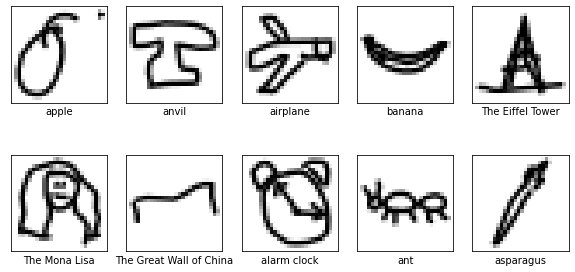

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
start = 0

# helper function used to plot images 
for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
    start += 10000
plt.show()

### Prepare data

In [ ]:
from sklearn.utils import shuffle

# It's a good idea to shuffle the training data before using it to build a model
x_train, y_train = shuffle(x_train, y_train)

# Normalize 
# we are scaling the pixel values between 0 and 1 by dividing by the largest pixel value (i.e. 255)
max_pixel_value = x_train.max()
x_train = x_train.astype('float32') / max_pixel_value
print(x_train.shape)

(100000, 784)


In [ ]:
# Check that our pixel values are indeed normalized 
assert x_train.min() == 0.0
assert x_train.max() == 1.0

In [ ]:
# imports 
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### Build the simple autoencoder
Notice that for the output layer, we are "borrowing" the same structure as the output of a binary class problem. A neuron with a sigmoid activation function outputs a single number -- the probability of being in the positive class. For our problem, the outputs are the $784$ pixel values which, like probabilities, are on the interval $[0, 1]$. Pixel values, however, are interpreted as the "brightness", or "lit-up-ness" of a pixel rather than as probabilities. So we can use $784$ neurons, each with a sigmoid activation function to produce our output pixel values.

In [ ]:
### build simple auto-encoder

# save input data dims to variable 
input_dims = x_train.shape[1]
shape = (input_dims,)

# decoder output size (i.e. 784 dims)
decoding_dim = input_dims

# encoder output size
latent_vect_dims = 32

# Create input layer 
inputs = Input(shape=shape)



# Create encoder layer 
# think of each layer as an individual function 
#                         y = f(x) 
# y = f(x) <=> layer_output = Dense(paramers)(layer_input)
encoded = Dense(latent_vect_dims, activation="relu")(inputs)


# Create decoder layer 
decoded = Dense(decoding_dim, activation="sigmoid")(encoded)

# bring it all together using the Model API
autoencoder_simple = Model(inputs=inputs, outputs=decoded, name="simple_autoencoder")

### Compile the simple autoencoder

In [ ]:
autoencoder_simple.compile(optimizer='nadam', loss='binary_crossentropy')

In [ ]:
autoencoder_simple.summary()

Model: "simple_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### Fit (train) the simple autoencoder

In [ ]:
%%time
import os
import datetime

from tensorflow.keras.callbacks import TensorBoard

# cut off training if loss doesn't decrease by a certain amount over X number of epoches 
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)

#  tensorboard callback
logdir = os.path.join("logs", f"SimpleAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

# fit the autoencoder model (train)
autoencoder_simple.fit(x_train, # input image to encoder
                        x_train, # provide input image to decoder so the model learns how to reconstruct the input image 
                        epochs=100,
                        batch_size=64,
                        shuffle=True,
                        validation_split=.2,
                        verbose = True,
                        callbacks=[stop, tensorboard], 
                        workers=10)

Epoch 1/100
1250/1250 [==============================] - 6s 3ms/step - loss: 0.2944 - val_loss: 0.2430
Epoch 2/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2329 - val_loss: 0.2276
Epoch 3/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2256 - val_loss: 0.2246
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2237 - val_loss: 0.2236
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2229 - val_loss: 0.2230
Epoch 6/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2224 - val_loss: 0.2225
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2220 - val_loss: 0.2224
Epoch 8/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2218 - val_loss: 0.2220
CPU times: user 31.9 s, sys: 2.84 s, total: 34.8 s
Wall time: 29.7 s


### Use the trained model to reconstruct the input images


In [ ]:
%%time
# encode and decode all the images
#     riginal images go in (i.e, x_train)
#     decoded images come out (i.e. a non-perfect reconstruction of x_train)
decoded_imgs = autoencoder_simple(x_train)

In [ ]:
decoded_imgs.shape

TensorShape([100000, 784])

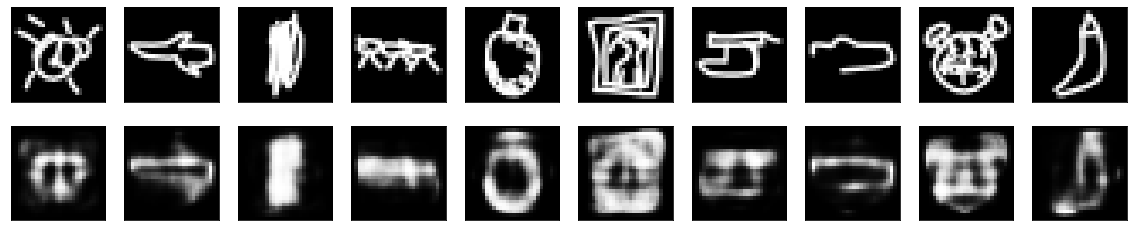

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

### helper fuction for plotting reconstructed and original images 
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

You'll be expected to discuss the components of a simple autoencoder and their purpose. 

# 2. Train an Autoencoder (Learn)
<a id="p2"></a>
In this section we will learn how to build and train deep autoencoders and convolutional autoencoders

## Overview

As long as our architecture maintains a symmetric "hourglass" shape, we can continue to add layers and create a deeper network. 

## Follow Along

## 2.1 Deep Autoencoder

In [ ]:
#                                encoder     ->    decoder 
# dim of each hidden layer: 784, 128, 64, 32 -> 64, 128, 784

# input layer 
inputs = Input(shape=(784,))

# 1st encoding layer (compresses input image into 128 dim vect)
encoded_1 = Dense(128, activation="relu")(inputs)

# 2nd encoding layer (compresses 128 dim vect into 64 dim vect)
encoded_2 = Dense(64, activation="relu")(encoded_1)

# 3rd encoding layer (compresses 64 dim vect into 32 dim vect)
# this is the final compression that the encoder performs 
encoded_3 = Dense(32, activation="relu")(encoded_2)

## all following layers belong to the decoder ## 

# 1st decoding layer (decompresses 32 dim vect into 64 dim vect)
decoding_1 = Dense(64, activation="relu")(encoded_3)

# 2nd decoding layer (decompresses 64 dim vect into 128 dim vect)
decoding_2 = Dense(128, activation="relu")(decoding_1)

# 3rd decoding layer (decompresses 128 dim vect into 784 dim vect)
decoding_3 = Dense(784, activation="sigmoid")(decoding_2)

# bring it all together using the Mode API
autoencoder_deep = Model(inputs=inputs, outputs=decoding_3, name="autoencoder_deep")


In [ ]:
autoencoder_deep.summary()

Model: "autoencoder_deep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 784)          

In [ ]:
%%time
# compile & fit model

autoencoder_deep.compile(optimizer='nadam', loss='binary_crossentropy')

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

logdir = os.path.join("logs", f"DeepAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder_deep.fit(x_train, 
                     x_train,
                     epochs=100,
                     batch_size=64,
                     shuffle=True,
                     validation_split=.2,
                     verbose = True,
                     callbacks=[stop, tensorboard], 
                     workers=10)

Epoch 1/100
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2836 - val_loss: 0.2511
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2397 - val_loss: 0.2324
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2264 - val_loss: 0.2220
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2186 - val_loss: 0.2165
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2126 - val_loss: 0.2103
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2083 - val_loss: 0.2078
Epoch 7/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2049 - val_loss: 0.2049
Epoch 8/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2019 - val_loss: 0.2011
Epoch 9/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1993 - val_loss: 0.2003
Epoch 10/100
1250/1250 [==============================] - 5s 4ms/step - l

### Use the trained model to reconstruct the input images

In [ ]:
%%time
decoded_imgs = autoencoder_deep.predict(x_train)

CPU times: user 3.85 s, sys: 627 ms, total: 4.48 s
Wall time: 3.4 s


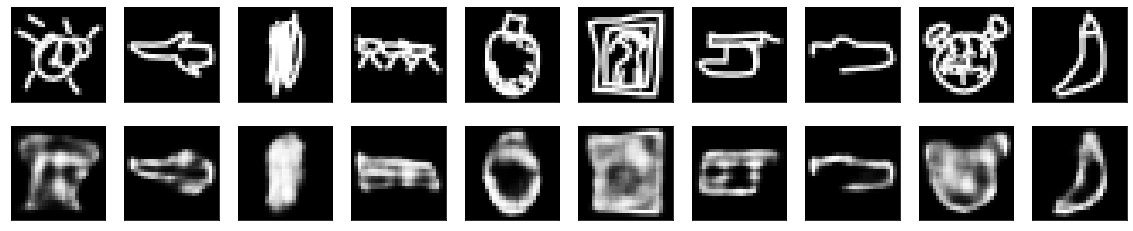

In [ ]:
# display a set of input images vs. their reconstructions using matplotlib 
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##2.2 Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist of a stack of `Conv2D` and `MaxPooling2D` layers, while the decoder will consist of a stack of `Conv2D` and `UpSampling2D` layers. Here `MaxPooling2D` layers and `Upsampling2D` layers are used for spatial down-sampling and up-sampling, respectively.

### Example Image of a Convolutional Autoencoder 

![](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)

In [ ]:
# we need to transfor our row vectors back into matrices
# because the convolutional and pooling layers expect images in the form of matrices 
x_train = x_train.reshape((x_train.shape[0], 28, 28))
x_train[0].shape

(28, 28)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model

# define some parameters and the dims of each, individual sample 
input_shape = (28,28,1)

# weight matrix parameters
# size of the convolution kernel (or filter)
conv_filter_size = (3,3)
pooling_filter_size = (2,2)

# input layer 
inputs = Input(shape=input_shape)

### encoding layers ### 
# This layer takes 28x28 image as input and produces 16 feature maps of size 14x14
encoded = Conv2D(16, conv_filter_size, activation="relu", padding="same")(inputs)
encoded = MaxPooling2D(pooling_filter_size, padding="same")(encoded)

# This layer takes the previous layer as input and produces 8 feature maps of size 7x7
encoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(pooling_filter_size, padding="same")(encoded)

# This layer takes the previous layer as input and produces 8 feature maps of size 4x4
encoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(encoded)
encoded = MaxPooling2D(pooling_filter_size, padding="same")(encoded)

# flatten 3D tensor into 1D vector in preparation for the Dense layer 
encoded_vect = Flatten()(encoded)
# 128 = 4 * 4 * 8
encoded_vect = Dense(128, activation="relu")(encoded_vect)

# reshape 1D vectors into 2D matrices 
encoded = Reshape((4,4,8))(encoded_vect)

### decoding layers ###
decoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(encoded)
decoded = UpSampling2D(pooling_filter_size)(decoded)
                  
decoded = Conv2D(8, conv_filter_size, activation="relu", padding="same")(decoded)
decoded = UpSampling2D(pooling_filter_size)(decoded)
                  
decoded = Conv2D(16, conv_filter_size, activation="relu")(decoded)
decoded = UpSampling2D(pooling_filter_size)(decoded)

# because this is the final reconstruction of the original image
# we must necessarily use a single weight matrix for the convolution 
# so that the final output is a 2D matrix and not a rank 3 Tensor (i.e. a volume)
decoded = Conv2D(1, conv_filter_size, activation="sigmoid", padding="same")(decoded)

# bring it all together using the Mode API
conv_autoencoder = Model(inputs=inputs, outputs=decoded, name="conv_autoencoder")

In [ ]:
conv_autoencoder.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)      

In [ ]:
%%time
# compile & fit model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os
import datetime

conv_autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

# make tensorboard callback
from tensorflow.keras.callbacks import TensorBoard
logdir = os.path.join("logs", f"ConvolutionalAutoencoder")
tensorboard = TensorBoard(log_dir=logdir)

# early stopping callback
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)


conv_autoencoder.fit(x_train, 
                     x_train,
                     epochs=50,
                     batch_size=32,
                     shuffle=True,
                     validation_split=.2,
                     verbose = True,
                     callbacks=[stop, tensorboard], 
                     workers=10)

Epoch 1/50
2500/2500 [==============================] - 32s 7ms/step - loss: 0.2597 - val_loss: 0.2327
Epoch 2/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2209 - val_loss: 0.2132
Epoch 3/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2094 - val_loss: 0.2069
Epoch 4/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2031 - val_loss: 0.2011
Epoch 5/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1991 - val_loss: 0.1977
Epoch 6/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1962 - val_loss: 0.1952
Epoch 7/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1939 - val_loss: 0.1934
Epoch 8/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1921 - val_loss: 0.1917
Epoch 9/50
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1907 - val_loss: 0.1900
Epoch 10/50
2500/2500 [==============================] - 16s 6ms/step - l

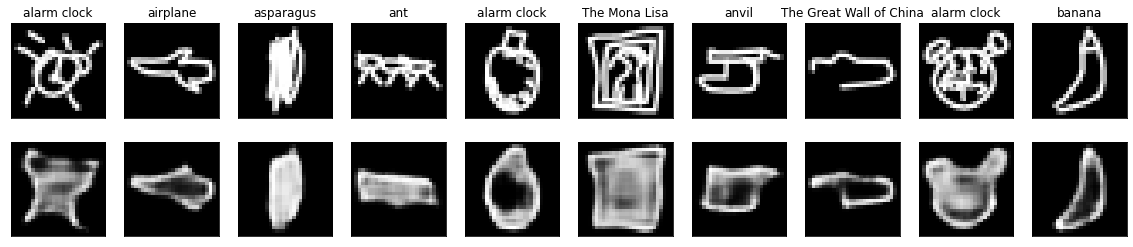

In [ ]:
import matplotlib.pyplot as plt

decoded_imgs = conv_autoencoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Visualization of the Representations (codings)

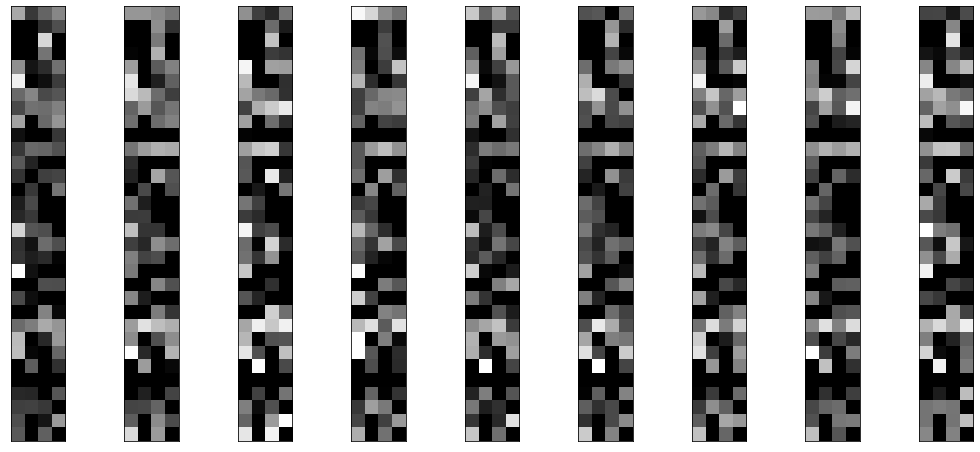

In [ ]:
# we have isolated the encoder portion of our auto-encoder so that we can access the encoder vector (i.e. the output of the encoder)
encoder = Model(inputs=inputs, outputs=encoded)

# the predictions (i.e. the output) of our encoder model are the original images encoder into a smaller dim space (i.e. the encoder vectors)
encoded_imgs = encoder.predict(x_train)

# display the codings for the above input images
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


The above images are the $128$-dimensional encoded vectors (codings), represented as $4\times32$ images, for some of the input images from `x_train`<br>
Notice that we really can't interpret the encoded vectors -- this is the price we pay for dimensionality reduction! The features in the encoded vectors are *non-linear* combinations of the input features. <br>
This is the same give and take that we experienced with PCA (Principal Components Analysis) -- which is *linear* dimensionality reduction.<br>
Reference: [Principal Component Analysis Explained Visually](https://setosa.io/ev/principal-component-analysis/). 

## Challenge

You will be expected to build and train autoencoders at some point in the near future!

# 3. Application of Autoencoders: Information Retrieval (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

We are going to perform the following: 

- Build an encoder model
- Train a NearestNeighbors on encoded images
- Choose a query image 
- Find similar encoded images using the trained NearestNeighbors model
- Check our results: make sure that the selected images are in fact similar to the query image!

### 3.1 Build an encoder model

Use the `Model` class and the encoder layers to build an encoded model. Remember that we first need to train a full autoencoder model, which has both an encoder and and a decoder, before we can "break off" the trained encoder portion. 

In [ ]:
encoded.shape

TensorShape([None, 4, 4, 8])

In [ ]:
# we have isolated the encoder portion of the convolutional auto-encoder 
#     we built in Section 2, so that we can access the coding representations of the images 
#     (i.e. the output of the encoder)
# Now flatten the coding to a vector
encoded_flat = Flatten()(encoded)

# Build the encoder, which is going to take input images and produce flattened coding vectors
encoder = Model(inputs=inputs, outputs=encoded_flat)

# Run the encoder on the input data set
encoded_imgs = encoder.predict(x_train)

In [ ]:
# now we can pass in our row vectors into a Nearest Neighbors model
encoded_imgs.shape

(100000, 128)

###3.2  Train a NearestNeighbors model

Build a `NearestNeighbors` model and train it on the encoded images. 


In [ ]:
%%time
from sklearn.neighbors import NearestNeighbors

# fit KNN on encoded images (i.e. the encoded vectors)
nn = NearestNeighbors(n_neighbors=11, algorithm='ball_tree')

# pass in the encoded images (i.e. the encoded vectors )
nn.fit(encoded_imgs)

CPU times: user 1.77 s, sys: 5.77 ms, total: 1.77 s
Wall time: 1.76 s


### Select a query image

Next, we chose an image that we will pass into the `NearestNeighbors` model in order to find similar images. <br>
Feel free to select a different image.

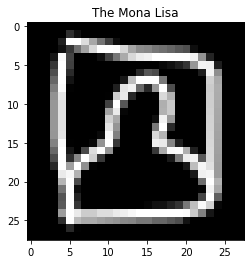

In [ ]:
# get a query image 
query =  5000

# we will pass the query image into NearestNeighbors in order to find similar images, 
#      by identifying images whose encoded vectors are closest in distance to the query image's encoded vector
plt.title(class_names[y_train[query]])
plt.imshow(x_train[query]);

### 3.3 Find and Retrieve Images that are Similar to the Query Image
Use the encoder to encode our query image

In [ ]:
query_img = x_train[query]
query_img.shape

(28, 28)

In [ ]:
# format the query image for input to our model
query_img_reshaped.shape

(1, 28, 28)

In [ ]:
# encode the query image to a lower dimensional vector using our encoder model 
query_img_encoded = encoder.predict(query_img_reshaped)

In [ ]:
query_img_encoded.shape

(1, 128)

Select the 10 nearest neighbor images to our query image

In [ ]:
neigh_dist, neigh_ind = nn.kneighbors(query_img_encoded)

Nearest neighbor distances:

In [ ]:
neigh_dist.round(3)[0][1:]

array([4.271, 4.421, 4.486, 4.542, 4.609, 4.658, 4.728, 4.735, 4.747,
       4.761])

Nearest neighbor indexes: <br>
Of course the model identifies the query image as the closest nearest neighbor to itself. <br>
That's why we asked for 11 nearest neigbhbors when really we wanted 10!

In [ ]:
neigh_ind

array([[ 5000,  6808, 10641, 16278, 38872, 81160, 27718, 65043,  7481,
        49029,  8573]])

### 4. How did our model perform?
Let's check!

Image 0: The Mona Lisa
Image 1: The Mona Lisa
Image 2: The Mona Lisa
Image 3: The Mona Lisa
Image 4: The Mona Lisa
Image 5: The Mona Lisa
Image 6: The Mona Lisa
Image 7: The Mona Lisa
Image 8: The Mona Lisa
Image 9: The Mona Lisa


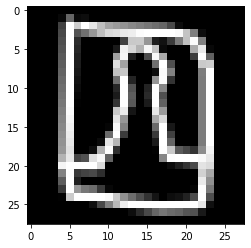

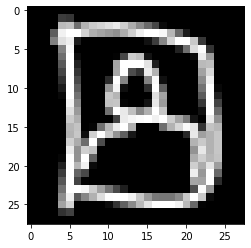

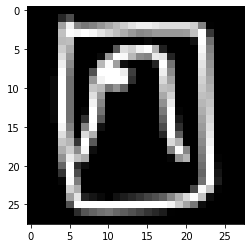

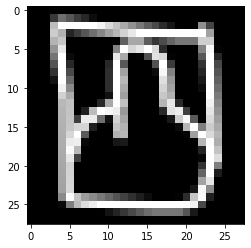

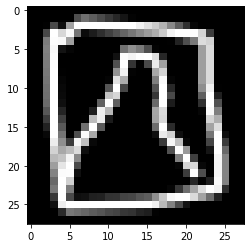

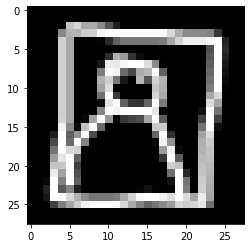

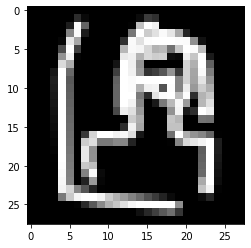

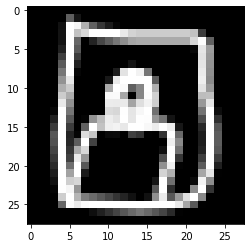

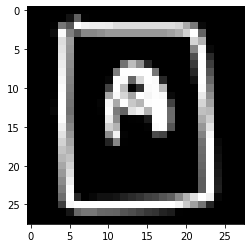

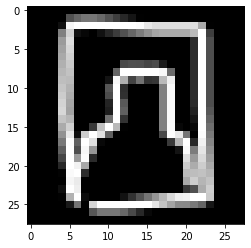

In [ ]:
count = 0
for nearest_neigh_index in neigh_ind[0][1:]:
  plt.figure()
  plt.imshow(x_train[nearest_neigh_index])
  print(f'Image {count}: {class_names[y_train[nearest_neigh_index]]}')
  count+=1

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know which part of the autoencoder (the encoder) to use to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the components of an autoencoder
    - Encoder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do this easily in Keras
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AutoEncoders are used for dimensionality reduction, reverse image search, and many more applications. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__<br>
- [AI Summer -- autoencoder resources](https://theaisummer.com/search/?s=autoencoders)